In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from PIL import Image
from tqdm import tqdm
import os
import math


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error


def show(x_test,target,idx,model):
    a=np.expand_dims(x_test[target+idx], axis=0)
    prd=model.predict(a)
    aa=[]
    for b in prd[0][-1]:
        bb=[]
        for c in b:
            bb.append([c,c,c])
        aa.append(bb)
    aa=np.array(aa)[:,:,:,0]
    if idx==0:
        predict=np.expand_dims(aa,axis=0)
    else:
        predict = np.concatenate((predict, np.expand_dims(aa,axis=0)), axis=0)
def MAPE(y_test, y_pred,vervose=1):
    # print(y_test.shape, y_pred.shape)
    all=(zip(y_test,y_pred))
    
    cnt=0
    cost=0
    up=0
    down=0
    for t,p in all:#t로나눠
        if t==0:
            # c=np.abs(t-p) / p
            continue
        else:
            c=np.abs(t-p) / t
            cnt+=1
            cost+=c
            # if c>0.5:
            #     if t> 40:
            #         up+=1
            #     else:
            #         down+=1
            # if c>0.2:
            #     print(t)
    if vervose==1:
        print(f"up: {up}  down : {down}")
    return cost/cnt*100


def compute_metrics(original,predict,start,end):
    start-=1
    end-=1
    y=original[:,start:end,:,:]
    y_pred=predict[:,start:end,:,:]
    
    # mape=MAPE(y.reshape(-1,),y_pred.reshape(-1,))
    y=(y)*100
    y_pred=(y_pred)*100

    y_flatten=y.flatten()
    y_pred_flatten=y_pred.flatten()

    mape=MAPE(y_flatten,y_pred_flatten,0)

    mse=mean_squared_error(y_flatten,y_pred_flatten)
    mae=mean_absolute_error(y_flatten,y_pred_flatten)
    return np.array([mse,mape,mae])



def metrics_(y,y_pred):
    
    y=(y)*100
    y_pred=(y_pred)*100

    y_flatten=y.flatten()
    y_pred_flatten=y_pred.flatten()


    mape=MAPE(y_flatten,y_pred_flatten)
    mse=mean_squared_error(y_flatten,y_pred_flatten)
    mae=mean_absolute_error(y_flatten,y_pred_flatten)
    return [mse,mape,mae]

def metrics_jam(y,y_pred):
    
    y=(y)*100
    y_pred=(y_pred)*100
    # 속도 40이하만 필터링
    y_filtered=y[y <40]
    y_pred_filtered=y_pred[y < 40]

    
    mape=MAPE(y_filtered,y_pred_filtered)
    mse=mean_squared_error(y_filtered,y_pred_filtered)
    mae=mean_absolute_error(y_filtered,y_pred_filtered)
    return [mse,mape,mae]

def _predict(models,i, x_test ,target):
    for idx in range(7):
        a=np.expand_dims(x_test[target+idx], axis=0)

        prd=models[i].predict(a)
        #gray에서 이미지보여주려고 ch3만듬
        all=[]
        #예측된거 마지막꺼만 가져옴
        for img in prd[0][-1]:
            pixel=[]
            for gray in img:
                pixel.append([gray,gray,gray])
            all.append(pixel)
        all=np.array(all)[:,:,:,0]
    
        if idx==0:
            predict=np.expand_dims(all,axis=0)
            
        else:
            predict = np.concatenate((predict, np.expand_dims(all,axis=0)), axis=0)
    return predict



def make_predict(models, model_num, x_test ,target,original):
    predicts=[]
    for i in range(model_num):
    
        predict=_predict(models,i,x_test,target)

        print()
        print(f"{i}번째")
        print("속도 전체 에러율")
        mse,mape,mae=metrics_(1-original[:,:,:,0],1-predict[:,:,:,0])
        print(f"rmse : {np.sqrt(mse)} , mape : {mape} , mae : {mae}")
        print("속도 40이하 에러율")
        mse,mape,mae=metrics_jam(1-original[:,:,:,0],1-predict[:,:,:,0])
        print(f"rmse : {np.sqrt(mse)} , mape : {mape} , mae : {mae}")

        #모든 모델 확인하기 위해 리스트에 저장
        predicts.append(predict)
    return predicts


# test all 2020

In [34]:


path="D:/npz_gray_7_64_fix"

models=[]




# models.append(keras.models.load_model('fixversion_128_layer3_0.00001_mse.h5'))
models.append(keras.models.load_model('fixversion_128_layer5_0.001_mse.h5'))
# models.append(keras.models.load_model('fixversion_128_layer5_0.0008_mse.h5'))

models.append(keras.models.load_model('fixversion_128_layer5_0.001_mape.h5'))
models.append(keras.models.load_model('fixversion_128_layer5_0.0008_mape.h5'))
# models.append(keras.models.load_model('fixversion_128_layer5_0.0004_mape.h5'))
# models.append(keras.models.load_model('fixversion_128_layer5_0.0005_mape_0.1.h5'))







0번째
속도 전체 에러율
up: 0  down : 0
rmse : 8.544936199478206 , mape : 17.5010517508423 , mae : 4.791512093405509
속도 40이하 에러율
up: 0  down : 0
rmse : 7.016036099039401 , mape : 18.938756021078852 , mae : 3.6232616076334865


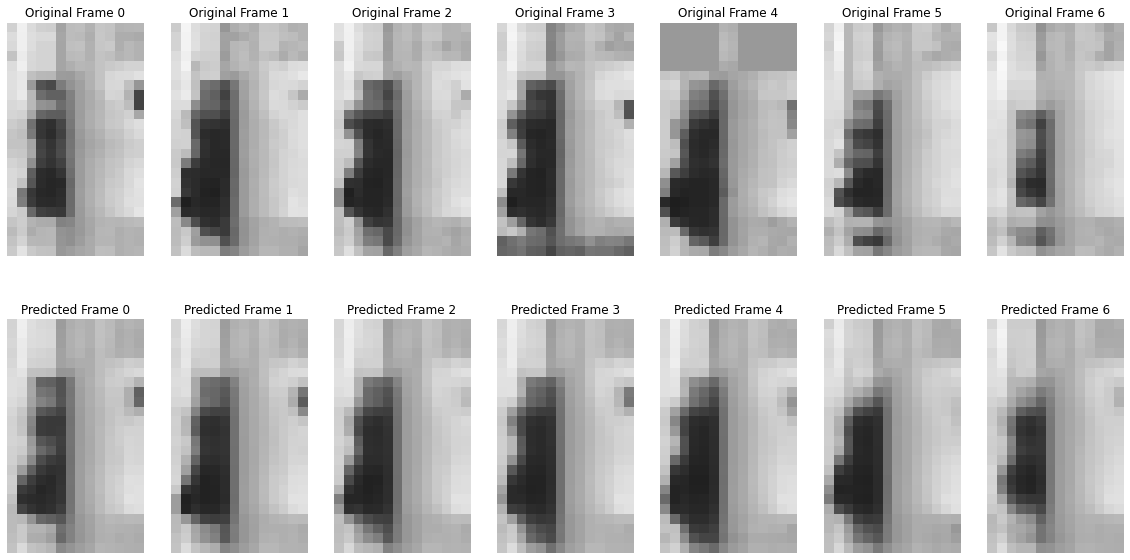

In [11]:
# 모든 모델 훈련시킨걸로 확인하기
x_test = np.load(f"{path}/batch/x/3.npz")['x']
target=5 # 
originals=[]
predicts=[]

model_num=1

#원본데이터
original=x_test[target+7]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)


fig, axes = plt.subplots(model_num+1, 7, figsize=(20, 10))
# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    #inverse여서 1에서 빼준다
    ax.imshow((original[idx]))
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

for i in range(model_num):
    for idx, ax in enumerate(axes[i+1]):
        ax.imshow(predicts[i][idx])
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")




0번째
속도 전체 에러율
up: 0  down : 0
rmse : 10.443604234224393 , mape : 27.141034996141723 , mae : 6.675127015426125
속도 40이하 에러율
up: 0  down : 0
rmse : 8.649110685295788 , mape : 30.120116700158523 , mae : 5.312550521450825

1번째
속도 전체 에러율
up: 0  down : 0
rmse : 10.322591888851003 , mape : 23.18040928344035 , mae : 6.257941354910374
속도 40이하 에러율
up: 0  down : 0
rmse : 7.6327364056480596 , mape : 24.26354941411201 , mae : 4.209453999647207

2번째
속도 전체 에러율
up: 0  down : 0
rmse : 9.370155723654957 , mape : 23.573006972158463 , mae : 5.851982688119096
속도 40이하 에러율
up: 0  down : 0
rmse : 7.950468491883786 , mape : 26.3178123360223 , mae : 4.749682742526504

3번째
속도 전체 에러율
up: 0  down : 0
rmse : 9.603778211937637 , mape : 19.405565752432672 , mae : 5.004207033200376
속도 40이하 에러율
up: 0  down : 0
rmse : 8.664454299182692 , mape : 21.130652505805795 , mae : 4.0415930494468855

4번째
속도 전체 에러율
up: 0  down : 0
rmse : 10.237128922326097 , mape : 32.35449787077427 , mae : 6.914972556325869
속도 40이하 에러율
up: 0  dow

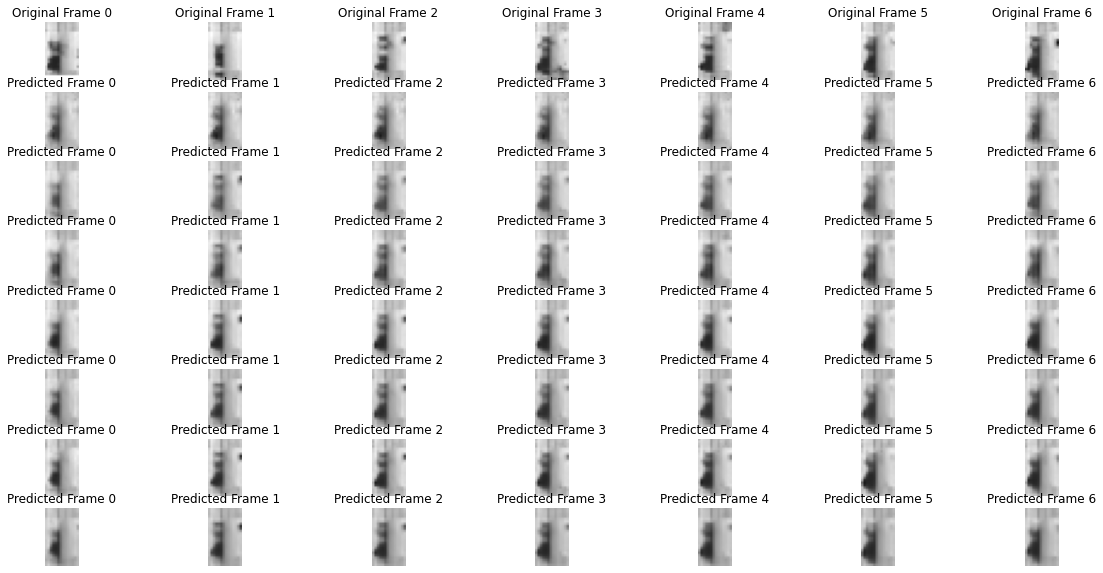

In [26]:
# 모든 모델 새로운데이터로 확인하기

x_test = np.load(f"{path}/2020/7.npz")['arr_0']
target=6 # 
originals=[]
predicts=[]
model_num=7

#원본데이터
original=x_test[target+6]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)


fig, axes = plt.subplots(model_num+1, 7, figsize=(20, 10))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(original[idx])
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

for i in range(model_num):
    for idx, ax in enumerate(axes[i+1]):
        ax.imshow(predicts[i][idx])
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")


In [13]:
# 2020년 (훈련안시킨거) 모든거 예측하고 매트릭 확인
batch_size=64
win=7
total=[]
for k in range(7):
    before_list=[]
    after_list=[]
    peak_list=[]
    rest_list=[]
    # for i in tqdm(list):
    x_test = np.load(f"{path}/2020/4.npz")['arr_0']
    for target in range(batch_size-win+1):


        predict=_predict(models,k,x_test,target)
        
        
        original=x_test[target+6]
        all=[]
        for a in original:
            aa=[]
            for b in a:
                bb=[]
                for c in b:
                    bb.append([c,c,c])
                aa.append(bb)
            all.append(aa)
        
        original=np.array(all)[:,:,:,:,0]

        #before peak hour - 7~12
        before=compute_metrics(original,predict,7,12)
        #peak 12~19
        peak=compute_metrics(original,predict,12,19)
        #after 19~21
        after=compute_metrics(original,predict,19,21)

        #rest 22~24 , 0~6
        y=original[:,21:23,:,:]
        y_pred=predict[:,21:23,:,:]
        # 22~24 0~6 시간대 합치기
        y=np.concatenate((y,original[:,0:5,:,:]),axis=1)
        y_pred=np.concatenate((y_pred,predict[:,0:5,:,:]),axis=1)
        # rest 에러 계산
        y=(y)*100
        y_pred=(y_pred)*100
        y_flatten=y.flatten()
        y_pred_flatten=y_pred.flatten()
        mape=MAPE(y_flatten,y_pred_flatten,0)
        mse=mean_squared_error(y_flatten,y_pred_flatten)
        mae=mean_absolute_error(y_flatten,y_pred_flatten)
        rest=[mse,mape,mae]
        
        #전체 저장
        before_list.append(before)
        after_list.append(after)
        peak_list.append(peak)
        rest_list.append(rest)


    total.append(np.array((np.array(before_list),np.array(peak_list),np.array(after_list),np.array(rest_list))))
total=np.array(total)

In [14]:
total.shape

(7, 4, 58, 3)

In [15]:
# mse,mape,mae
for i in range(7):
    print(f"{i}번째")
    print("before")
    print(np.mean(total[i][0],axis=0))
    print("peak")
    print(np.mean(total[i][1],axis=0))
    print("after")
    print(np.mean(total[i][2],axis=0))
    print("rest")
    print(np.mean(total[i][3],axis=0))
    print("표준편차")
    print("before")
    print(np.std(total[i][0],axis=0))
    print("peak")
    print(np.std(total[i][1],axis=0))
    print("after")
    print(np.std(total[i][2],axis=0))
    print("rest")
    print(np.std(total[i][3],axis=0))

0번째
before
[164.97783474  16.79666045   8.72590925]
peak
[126.17181488  16.81141288   6.81418139]
after
[186.3365868   24.83164898   8.5555942 ]
rest
[93.37329513 10.49836471  6.38261177]
표준편차
before
[47.7635127   2.75404809  1.14008832]
peak
[66.29523451  3.60301404  1.4284891 ]
after
[62.43867972  4.97651962  1.5896146 ]
rest
[41.13031332  2.59587088  1.55058497]
1번째
before
[141.8710468   14.9104821    7.69819646]
peak
[108.10435918  20.25593301   6.75497185]
after
[188.28771387  32.21781875   8.82461516]
rest
[74.81685074  8.4084724   5.02413437]
표준편차
before
[35.81340644  2.488576    1.01657023]
peak
[36.45225163  2.65810119  0.88794378]
after
[45.66896152  5.23756057  1.17210544]
rest
[40.92073743  2.27015546  1.32022542]
2번째
before
[112.6794493   12.8819082    6.84679874]
peak
[73.46096024 13.81229893  5.45660225]
after
[153.03009708  27.13415515   7.96472977]
rest
[67.39814648  8.49601073  5.35308475]
표준편차
before
[30.74993577  2.04790507  0.8984044 ]
peak
[23.0689446   1.8220838 

In [ ]:
# mse,mape,mae
print("before")
print(np.mean(total2[0][0],axis=0))
print("peak")
print(np.mean(total2[0][1],axis=0))
print("after")
print(np.mean(total2[0][2],axis=0))
print("rest")
print(np.mean(total2[0][3],axis=0))
print("표준편차")
print("before")
print(np.std(total2[0][0],axis=0))
print("peak")
print(np.std(total2[0][1],axis=0))
print("after")
print(np.std(total2[0][2],axis=0))
print("rest")
print(np.std(total2[0][3],axis=0))

In [152]:
# mse,mape,mae
print("before")
print(np.mean(total[0][0],axis=0))
print("peak")
print(np.mean(total[0][1],axis=0))
print("after")
print(np.mean(total[0][2],axis=0))
print("rest")
print(np.mean(total[0][3],axis=0))
print("표준편차")
print("before")
print(np.std(total[0][0],axis=0))
print("peak")
print(np.std(total[0][1],axis=0))
print("after")
print(np.std(total[0][2],axis=0))
print("rest")
print(np.std(total[0][3],axis=0))

before
[30.09655889 30.41768951  4.20539981]
peak
[37.12391396 40.70233267  4.71663537]
after
[53.34358836 58.21013672  5.59674044]
rest
[24.09878969 12.29736551  3.89083012]
표준편차
before
[2.39452783 7.41034072 0.25136129]
peak
[3.20528185 8.51993725 0.20975115]
after
[ 6.59026685 11.01835599  0.42641541]
rest
[4.56067598 2.99438791 0.32004584]


In [43]:
# 2020년 (훈련안시킨거) 모든거 예측하고 매트릭 확인
batch_size=64
win=7
total=[]
for k in range(20):
    before_list=[]
    after_list=[]
    peak_list=[]
    rest_list=[]
    # for i in tqdm(list):
    x_test = np.load(f"{path}/2020/{k}.npz")['arr_0']
    for target in range(batch_size-win+1):


        predict=_predict(models,1,x_test,target)
        
        
        original=x_test[target+7]
        all=[]
        for a in original:
            aa=[]
            for b in a:
                bb=[]
                for c in b:
                    bb.append([c,c,c])
                aa.append(bb)
            all.append(aa)
        
        original=np.array(all)[:,:,:,:,0]

        #before peak hour - 7~12
        before=compute_metrics(original,predict,7,12)
        #peak 12~19
        peak=compute_metrics(original,predict,12,19)
        #after 19~21
        after=compute_metrics(original,predict,19,21)

        #rest 22~24 , 0~6
        y=original[:,21:23,:,:]
        y_pred=predict[:,21:23,:,:]
        # 22~24 0~6 시간대 합치기
        y=np.concatenate((y,original[:,0:5,:,:]),axis=1)
        y_pred=np.concatenate((y_pred,predict[:,0:5,:,:]),axis=1)
        # rest 에러 계산
        y=(y)*100
        y_pred=(y_pred)*100
        y_flatten=y.flatten()
        y_pred_flatten=y_pred.flatten()
        mape=MAPE(y_flatten,y_pred_flatten,0)
        mse=mean_squared_error(y_flatten,y_pred_flatten)
        mae=mean_absolute_error(y_flatten,y_pred_flatten)
        
        rest=[mse,mape,mae]
        
        #전체 저장
        before_list.append(before)
        after_list.append(after)
        peak_list.append(peak)
        rest_list.append(rest)


    total.append(np.array((np.array(before_list),np.array(peak_list),np.array(after_list),np.array(rest_list))))
total=np.array(total)

IndexError: index 64 is out of bounds for axis 0 with size 64

In [17]:
# 2020년 (훈련안시킨거) 모든거 예측하고 매트릭 확인
batch_size=64
win=7
total=[]
for k in range(20):
    times=[]
    x_test = np.load(f"{path}/2020/{k}.npz")['arr_0']
    
    for target in range(batch_size-win+1):
        predict=_predict(models,3,x_test,target)
        
        
        original=x_test[target+7]
        all=[]
        for a in original:
            aa=[]
            for b in a:
                bb=[]
                for c in b:
                    bb.append([c,c,c])
                aa.append(bb)
            all.append(aa)
        original=np.array(all)[:,:,:,:,0]


        time=[]
        for i in range(1,25):
            time.append(compute_metrics(original,predict,i,i+1))
        

        
        #전체 저장
        times.append(np.array(time))

    total.append(np.array(times))
total=np.array(total)

In [24]:
total.shape

(20, 58, 24, 3)

In [25]:
total[1][1].shape

(24, 3)

In [ ]:
# mse,mape,mae
print("before")
print(np.mean(total[0][0],axis=0))
print("peak")
print(np.mean(total[0][1],axis=0))
print("after")
print(np.mean(total[0][2],axis=0))
print("rest")
print(np.mean(total[0][3],axis=0))
print("표준편차")
print("before")
print(np.std(total[0][0],axis=0))
print("peak")
print(np.std(total[0][1],axis=0))
print("after")
print(np.std(total[0][2],axis=0))
print("rest")
print(np.std(total[0][3],axis=0))


0번째
속도 전체 에러율
up: 0  down : 0
rmse : 8.21211905268589 , mape : 20.262278525821046 , mae : 5.340851380524673
속도 40이하 에러율
up: 0  down : 0
rmse : 4.8074153894656435 , mape : 21.037832453017245 , mae : 3.338552555987313

1번째
속도 전체 에러율
up: 0  down : 0
rmse : 8.535257897743396 , mape : 17.889518996191246 , mae : 4.6026156571836205
속도 40이하 에러율
up: 0  down : 0
rmse : 6.899196507605867 , mape : 19.135232772047278 , mae : 3.470951642742728

2번째
속도 전체 에러율
up: 0  down : 0
rmse : 8.671831799766833 , mape : 30.095459632365273 , mae : 6.2853923410324315
속도 40이하 에러율
up: 0  down : 0
rmse : 7.424812668580757 , mape : 35.56824573032154 , mae : 5.712188648977577


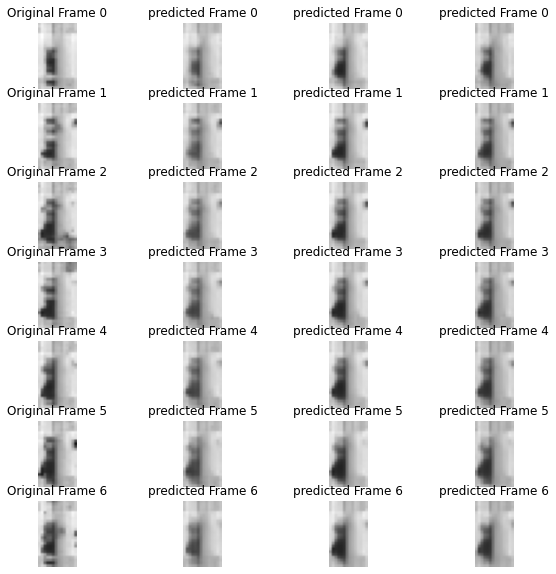

In [41]:
# 모든 모델 새로운데이터로 확인하기

x_test = np.load(f"{path}/2020/7.npz")['arr_0']
target=6 # 
originals=[]
predicts=[]
model_num=3

#원본데이터
original=x_test[target+7]

all=[]
for img in original:
    # print(a.shape)
    one_img=[]
    for pixels in img:
        pixel=[]
        for gray in pixels:
            pixel.append([gray,gray,gray])
        one_img.append(pixel)
    all.append(one_img)
original=np.array(all)[:,:,:,:,0]

predicts=make_predict(models, model_num, x_test ,target,original)


fig, axes = plt.subplots(7, model_num+1, figsize=(10, 10))

# Plot the original frames.
# for idx, ax in enumerate(axes[0]):
#     ax.imshow(original[idx])
#     ax.set_title(f"Original Frame {idx}")
#     ax.axis("off")

# for i in range(model_num):
#     for idx, ax in enumerate(axes[i+1]):
#         ax.imshow(predicts[i][idx])
#         ax.set_title(f"Predicted Frame {idx}")
#         ax.axis("off")

for i in range(7):
    for idx, ax in enumerate(axes[i]):
        if idx==0:
            ax.imshow(original[i])
            ax.set_title(f"Original Frame {i}")
            ax.axis("off")
        elif idx==1:
            ax.imshow(predicts[0][i])
            ax.set_title(f"predicted Frame {i}")
            ax.axis("off")
        elif idx==2:
            ax.imshow(predicts[1][i])
            ax.set_title(f"predicted Frame {i}")
            ax.axis("off")
        else:
            ax.imshow(predicts[2][i])
            ax.set_title(f"predicted Frame {i}")
            ax.axis("off")